AR(1) Model

In [ ]:
import pandas as pd


data = pd.read_csv('averaged_pings.txt', sep=",", names=["Service", "Timestamp", "PingTime"])


data['PingTime'] = data['PingTime'].str.extract('(\d+)').astype(int)
train_data = data['PingTime'].values

data_validate = pd.read_csv('samplepings.txt', sep=",", names=["Service", "Timestamp", "PingTime"])
data_validate['PingTime'] = data_validate['PingTime'].str.extract('(\d+)').astype(int)
validation_data = data_validate['PingTime'].values


data.head()
data_validate



,Service,Timestamp,PingTime
0,Service: All Services,Timestamp : 2024-03-19 00:00:00,24
1,Service: All Services,Timestamp : 2024-03-19 00:00:30,20
2,Service: All Services,Timestamp : 2024-03-19 00:01:00,19
3,Service: All Services,Timestamp : 2024-03-19 00:01:30,20
4,Service: All Services,Timestamp : 2024-03-19 00:02:00,40
...,...,...,...
223,Service: All Services,Timestamp : 2024-03-19 01:51:30,21
224,Service: All Services,Timestamp : 2024-03-19 01:52:00,18
225,Service: All Services,Timestamp : 2024-03-19 01:52:30,19
226,Service: All Services,Timestamp : 2024-03-19 01:53:00,19


In [ ]:
import numpy as np

import numpy as np
import numpy as np

def metropolis_hastings_ar1(ping_times, iterations, burn_in=1000, proposal_std_dev={'alpha': 0.2, 'beta': 0.15, 'sigma': 0.2}):
    np.random.seed(42)

    alpha_samples = [0.0]
    beta_samples = [0.0]
    sigma_samples = [1.0]



    for i in range(iterations):

        alpha_proposal = np.random.normal(alpha_samples[-1], proposal_std_dev["alpha"])
        beta_proposal = np.random.normal(beta_samples[-1], proposal_std_dev["beta"])
        sigma_proposal = abs(np.random.normal(sigma_samples[-1], proposal_std_dev["sigma"]))


        log_likelihood_current = -np.sum((ping_times[1:] - (alpha_samples[-1] + beta_samples[-1] * ping_times[:-1]))**2) / (2 * sigma_samples[-1]**2)
        log_likelihood_proposal = -np.sum((ping_times[1:] - (alpha_proposal + beta_proposal * ping_times[:-1]))**2) / (2 * sigma_proposal**2)


        log_prior_current = -0.5 * ((alpha_samples[-1]**2) / 10**2 + (beta_samples[-1]**2) + (sigma_samples[-1]**2))
        log_prior_proposal = -0.5 * ((alpha_proposal**2) / 10**2 + (beta_proposal**2) + (sigma_proposal**2))


        log_p_accept = (log_likelihood_proposal + log_prior_proposal) - (log_likelihood_current + log_prior_current)


        if np.log(np.random.rand()) < log_p_accept:
            alpha_samples.append(alpha_proposal)
            beta_samples.append(beta_proposal)
            sigma_samples.append(sigma_proposal)
        else:
            alpha_samples.append(alpha_samples[-1])
            beta_samples.append(beta_samples[-1])
            sigma_samples.append(sigma_samples[-1])


    return alpha_samples[burn_in:], beta_samples[burn_in:], sigma_samples[burn_in:]


alpha_samples, beta_samples, sigma_samples = metropolis_hastings_ar1(train_data, 15000, burn_in=5000)


alpha_estimate = np.mean(alpha_samples)
beta_estimate = np.mean(beta_samples)
sigma_estimate = np.mean(sigma_samples)

alpha_estimate, beta_estimate, sigma_estimate




(12.839332350470615, 0.4308469156517692, 41.72410892206635)

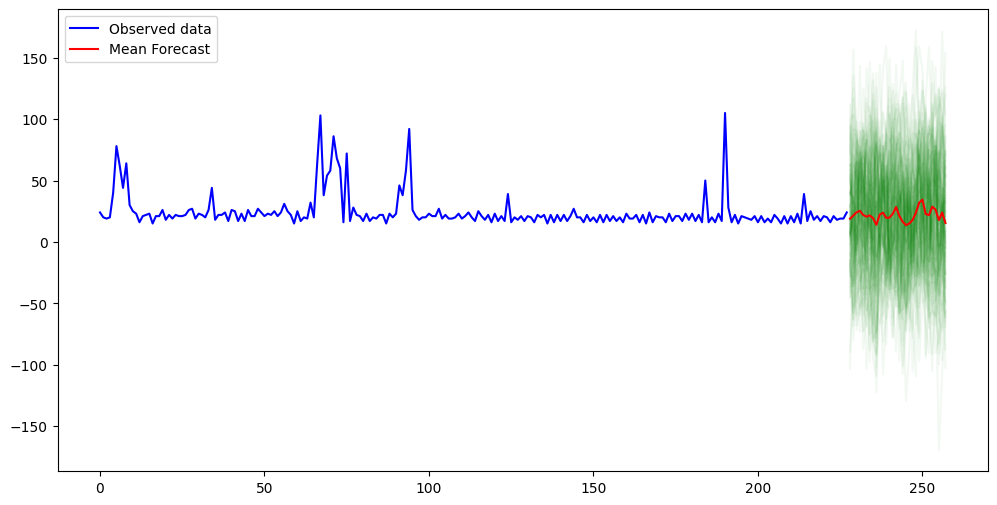

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecasts(data, alpha_samples, beta_samples, sigma_samples, steps_ahead, num_paths):



    plt.figure(figsize=(12, 6))
    times = np.arange(len(data))
    plt.plot(times, data, label='Observed data', color='blue')


    forecast_paths = []
    for _ in range(num_paths):

        alpha = np.random.choice(alpha_samples)
        beta = np.random.choice(beta_samples)
        sigma = np.random.choice(sigma_samples)

        forecast = [data[-1]]
        for _ in range(steps_ahead):
            forecast.append(alpha + beta * forecast[-1] + np.random.normal(0, sigma))

        forecast_paths.append(forecast[1:])
        plt.plot(times[-1:] + np.arange(1, steps_ahead + 1), forecast[1:], color='green', alpha=0.05)


    mean_forecast = np.mean(forecast_paths, axis=0)
    plt.plot(times[-1:] + np.arange(1, steps_ahead + 1), mean_forecast, color='red', label='Mean Forecast')

    plt.legend()
    plt.show()

plot_forecasts(validation_data, alpha_samples, beta_samples, sigma_samples, steps_ahead=30, num_paths=100)


In [ ]:
import numpy as np

def metropolis_hastings_ar2(ping_times, iterations, burn_in=1000, proposal_std_dev= {"alpha": 0.6, "beta1": 0.05, "beta2": 0.05, "sigma": 0.15}):
    np.random.seed(69)


    alpha_samples = [0.0]
    beta1_samples = [0.0]
    beta2_samples = [0.0]
    sigma_samples = [1.0]


    for i in range(iterations):

        alpha_proposal = np.random.normal(alpha_samples[-1], proposal_std_dev["alpha"])
        beta1_proposal = np.random.normal(beta1_samples[-1], proposal_std_dev["beta1"])
        beta2_proposal = np.random.normal(beta2_samples[-1], proposal_std_dev["beta2"])
        sigma_proposal = abs(np.random.normal(sigma_samples[-1], proposal_std_dev["sigma"]))


        preds_current = alpha_samples[-1] + beta1_samples[-1] * np.roll(ping_times, -1)[:-2] + beta2_samples[-1] * np.roll(ping_times, -2)[:-2]
        preds_proposal = alpha_proposal + beta1_proposal * np.roll(ping_times, -1)[:-2] + beta2_proposal * np.roll(ping_times, -2)[:-2]

        log_likelihood_current = -np.sum((ping_times[2:] - preds_current)**2) / (2 * sigma_samples[-1]**2)
        log_likelihood_proposal = -np.sum((ping_times[2:] - preds_proposal)**2) / (2 * sigma_proposal**2)


        log_prior_current = -0.5 * (alpha_samples[-1]**2 + beta1_samples[-1]**2 + beta2_samples[-1]**2 + sigma_samples[-1]**2)
        log_prior_proposal = -0.5 * (alpha_proposal**2 + beta1_proposal**2 + beta2_proposal**2 + sigma_proposal**2)


        log_p_accept = (log_likelihood_proposal + log_prior_proposal) - (log_likelihood_current + log_prior_current)


        if np.log(np.random.rand()) < log_p_accept:
            alpha_samples.append(alpha_proposal)
            beta1_samples.append(beta1_proposal)
            beta2_samples.append(beta2_proposal)
            sigma_samples.append(sigma_proposal)
        else:
            alpha_samples.append(alpha_samples[-1])
            beta1_samples.append(beta1_samples[-1])
            beta2_samples.append(beta2_samples[-1])
            sigma_samples.append(sigma_samples[-1])


    return alpha_samples[burn_in:], beta1_samples[burn_in:], beta2_samples[burn_in:], sigma_samples[burn_in:]



alpha_samples_ar2, beta1_samples_ar2, beta2_samples_ar2, sigma_samples_ar2 = metropolis_hastings_ar2(train_data, 15000, burn_in=5000)


alpha_estimate_ar2 = np.mean(alpha_samples_ar2)
beta1_estimate_ar2 = np.mean(beta1_samples_ar2)
beta2_estimate_ar2 = np.mean(beta2_samples_ar2)
sigma_estimate_ar2 = np.mean(sigma_samples_ar2)

alpha_estimate_ar2, beta1_estimate_ar2, beta2_estimate_ar2, sigma_estimate_ar2


(-0.04060054365071644,
 0.0011765348717918847,
 0.9999729504925381,
 2.689893201241294)

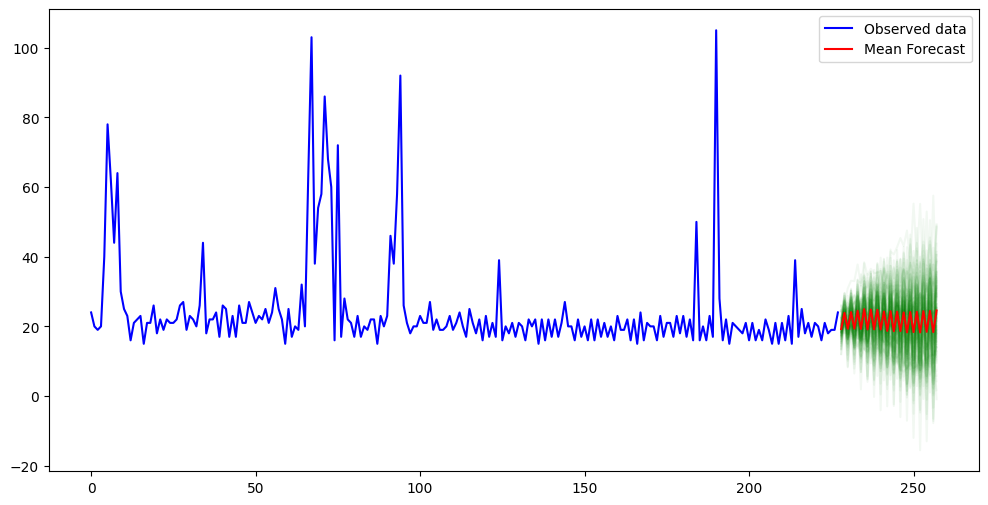

In [ ]:
def plot_forecasts_ar2(data, alpha_samples, beta1_samples, beta2_samples, sigma_samples, steps_ahead, num_paths):

    plt.figure(figsize=(12, 6))
    times = np.arange(len(data))
    plt.plot(times, data, label='Observed data', color='blue')


    forecast_paths = []
    for _ in range(num_paths):

        alpha = np.random.choice(alpha_samples)
        beta1 = np.random.choice(beta1_samples)
        beta2 = np.random.choice(beta2_samples)
        sigma = np.random.choice(sigma_samples)

        forecast = [data[-2], data[-1]]
        for _ in range(steps_ahead):
            next_point = alpha + beta1 * forecast[-1] + beta2 * forecast[-2] + np.random.normal(0, sigma)
            forecast.append(next_point)

        forecast_paths.append(forecast[2:])
        plt.plot(times[-1:] + np.arange(1, steps_ahead + 1), forecast[2:], color='green', alpha=0.05)


    mean_forecast = np.mean(forecast_paths, axis=0)
    plt.plot(times[-1:] + np.arange(1, steps_ahead + 1), mean_forecast, color='red', label='Mean Forecast')

    plt.legend()
    plt.show()


plot_forecasts_ar2(validation_data, alpha_samples_ar2, beta1_samples_ar2, beta2_samples_ar2, sigma_samples_ar2, steps_ahead=30, num_paths=100)


In [ ]:
from sklearn.metrics import mean_squared_error

def validate_bayesian_ar_models(data, train_size, iterations, burn_in):

    train_data = data[:train_size]
    validation_data = data[train_size:]


    alpha_samples_ar1, beta_samples_ar1, sigma_samples_ar1 = metropolis_hastings_ar1(
        train_data, iterations, burn_in=burn_in
    )
    alpha_ar1 = np.mean(alpha_samples_ar1[burn_in:])
    beta_ar1 = np.mean(beta_samples_ar1[burn_in:])

    forecasts_ar1 = [alpha_ar1 + beta_ar1 * train_data[-1]]
    for i in range(1, len(validation_data)):
        forecasts_ar1.append(alpha_ar1 + beta_ar1 * forecasts_ar1[-1])


    alpha_samples_ar2, beta1_samples_ar2, beta2_samples_ar2, sigma_samples_ar2 = metropolis_hastings_ar2(
        train_data, iterations, burn_in=burn_in, proposal_std_dev= {'alpha': 0.2, 'beta1': 0.15, 'beta2': 0.25, 'sigma': 0.2}
    )
    alpha_ar2 = np.mean(alpha_samples_ar2[burn_in:])
    beta1_ar2 = np.mean(beta1_samples_ar2[burn_in:])
    beta2_ar2 = np.mean(beta2_samples_ar2[burn_in:])


    forecasts_ar2 = [train_data[-2], train_data[-1]]
    for i in range(2, len(validation_data) + 2):
        next_forecast = alpha_ar2 + beta1_ar2 * forecasts_ar2[-1] + beta2_ar2 * forecasts_ar2[-2]
        forecasts_ar2.append(next_forecast)

    forecasts_ar2 = forecasts_ar2[2:]


    mse_ar1 = mean_squared_error(validation_data, forecasts_ar1[:len(validation_data)])
    mse_ar2 = mean_squared_error(validation_data, forecasts_ar2[:len(validation_data)])

    print(f"AR(1) Bayesian Model MSE: {mse_ar1}")
    print(f"AR(2) Bayesian Model MSE: {mse_ar2}")


train_sizes = [int(len(train_data) * 0.50),int(len(train_data) * 0.60) ,int(len(train_data) * 0.70),int(len(train_data) * 0.80),int(len(train_data) * 0.90),int(len(train_data) * 0.95)    ]
train_size = int(len(train_data) * 0.60)
iterations = 5000
burn_in = 1000


for train_size in train_sizes:
  print(f"--------------------------------------Size of training data {train_size}-----------------------------------------------")
  validate_bayesian_ar_models(train_data, train_size, iterations, burn_in)

--------------------------------------Size of training data 15840-----------------------------------------------
AR(1) Bayesian Model MSE: 147.35305177312793
AR(2) Bayesian Model MSE: 147.37655373243678
--------------------------------------Size of training data 19008-----------------------------------------------
AR(1) Bayesian Model MSE: 172.64086673276412
AR(2) Bayesian Model MSE: 172.64872151892874
--------------------------------------Size of training data 22176-----------------------------------------------
AR(1) Bayesian Model MSE: 213.5595922738172
AR(2) Bayesian Model MSE: 213.54516701872848
--------------------------------------Size of training data 25344-----------------------------------------------
AR(1) Bayesian Model MSE: 298.5689674414406
AR(2) Bayesian Model MSE: 299.13034919428594
--------------------------------------Size of training data 28512-----------------------------------------------
AR(1) Bayesian Model MSE: 71.66144829928548
AR(2) Bayesian Model MSE: 167.065

In [ ]:
import numpy as np

from sklearn.metrics import mean_squared_error

def grid_search_mh_ar2_for_mse(ping_times, train_size, iterations, burn_in):

    alpha_grid = [0.1,0.2, 0.5, 0.7]
    beta1_grid = [0.05, 0.1,0.15,0.25]
    beta2_grid = [0.05, 0.1, 0.15, 0.25]
    sigma_grid = [0.2,0.5, 0.7]


    train_data, validation_data = ping_times[:train_size], ping_times[train_size:]

    best_mse = np.inf
    best_params = None


    for alpha_sd in alpha_grid:
        print(f"started {alpha_sd}")
        for beta1_sd in beta1_grid:
            for beta2_sd in beta2_grid:
                for sigma_sd in sigma_grid:
                    proposal_std_dev = {"alpha": alpha_sd, "beta1": beta1_sd, "beta2": beta2_sd, "sigma": sigma_sd}


                    alpha_samples, beta1_samples, beta2_samples, sigma_samples = metropolis_hastings_ar2(
                        train_data, iterations, burn_in, proposal_std_dev
                    )


                    alpha_mean = np.mean(alpha_samples[burn_in:])
                    beta1_mean = np.mean(beta1_samples[burn_in:])
                    beta2_mean = np.mean(beta2_samples[burn_in:])


                    forecasts = [train_data[-2], train_data[-1]]
                    for i in range(2, 2 + len(validation_data)):
                        next_forecast = alpha_mean + beta1_mean * forecasts[-1] + beta2_mean * forecasts[-2]
                        forecasts.append(next_forecast)


                    forecasts = forecasts[2:]


                    mse = mean_squared_error(validation_data, forecasts)
                    print(f"{proposal_std_dev} gives us {mse}")


                    if mse < best_mse:
                        best_mse = mse
                        best_params = proposal_std_dev

    print(f"Best Proposal Standard Deviations: {best_params}")
    print(f"Lowest MSE: {best_mse}")
    return best_params


train_sizes = [int(len(train_data) * 0.80)]
iterations = 5000
burn_in = 1000

for train_size in train_sizes:
  grid_search_mh_ar2_for_mse(train_data, train_size,iterations,burn_in)